In [1]:
%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1588621913530_0002,pyspark,idle,Link,Link,


In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1588621913530_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-1.0.3-cp36-cp36m-manylinux1_x86_64.whl (10.0 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.2.1-cp36-cp36m-manylinux1_x86_64.whl (12.4 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (88 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.10.0-py3-none-any.whl (215 kB)
  Using cached scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl (26.1 MB)

In [3]:
df = spark.read.json('s3://sta9760-laura-spark-datasets/yelp-dataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
print(f'Total Columns: {len(df.dtypes)}')
print(f'Total Rows: {df.count():,}')
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393
root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable

In [8]:
#df.select('business_id','name','city','state','stars','categories').show(5, truncate=True)
df.createOrReplaceTempView('YelpBusiness')
sqldf = spark.sql(
'''
SELECT `business_id`, `name`, `city`, `state`, `categories`
FROM YelpBusiness

'''
)
sqldf.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

## How many unique categories are represented in this dataset?

In [11]:
from pyspark.sql.functions import split, explode, ltrim
df1 = sqldf.withColumn('categories',explode(split('categories',',')))
df1 = df1.withColumn('categories',ltrim(df1.categories))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
#df1 = df1.filter(df1.is_open==1)
df1.select('business_id','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

In [13]:
df1.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

In [15]:
df2=df1.groupby('categories').count().orderBy("count", ascending=False)
df2.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+
only showing top 20 rows

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#result_pdf = df2.orderBy("count", ascending=False).limit(20).toPandas().reset_index().set_index(['categories'])
result_pdf = df2.limit(20).toPandas()
#result_pdf.head()
# ax=result_pdf.plot.barh(x='categories', y='count')
# ax.invert_yaxis()
# ax = plt.gca()
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(6)
sns.barplot(result_pdf['count'],result_pdf['categories'],color="lightskyblue")    
plt.title('Top Categories by Business')
plt.xlabel('count')
plt.ylabel('category')
plt.tight_layout()
plt.legend('')
plt.box(False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

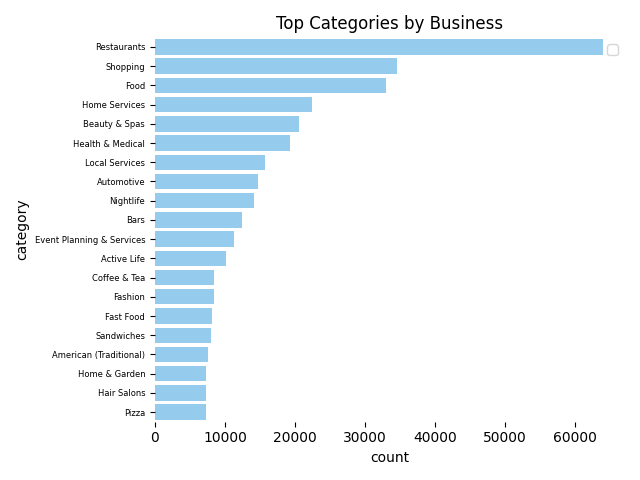

In [25]:
%matplot plt